In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from keras.models import Sequential , Model
from keras.layers import Dense,Flatten,Reshape,Dropout,LeakyReLU,Conv2DTranspose,Conv2D
from keras.optimizers import Adam,SGD
from keras.layers import  LeakyReLU, BatchNormalization, Input

In [3]:
from keras.datasets import mnist
(train_images, y_train), (_, _) = mnist.load_data()                                      # loading mnist data
print(len(train_images))
train_images=train_images[(y_train==0) | (y_train==1) | (y_train==5) | (y_train==7)]     # taking images with labels 1,2,3,4 for demostration purposes only
train_images=train_images[:5000]                                                          # taking only 5000 images

11490434/11490434 [==============================] - 0s 0us/step
60000


In [4]:
len(train_images)

5000

In [5]:
def plot_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.show()


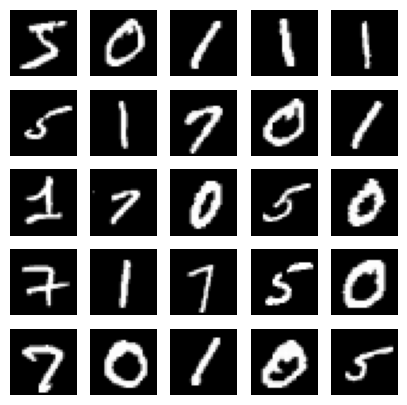

In [6]:
plot_images(train_images)

In [7]:
train_images=train_images.astype("float32")/127.5-1                         # normalising so that values are between -1 & +1
train_images=train_images.reshape(train_images.shape[0],28,28,1)            # now train_images has shape [5000,28,28,1]

In [8]:
def build_generator(latent_dim,input_shape):
    generator=Sequential([

        Dense(7*7*128 , input_dim=latent_dim),
        LeakyReLU(alpha=.2),
        Reshape((7, 7, 128)),
        BatchNormalization(),

        Conv2DTranspose(64 , (4,4) , padding="same" , strides=(2,2)),
        LeakyReLU(alpha=.2),
        BatchNormalization(),

        Conv2DTranspose(32 , (4,4) , padding="same" , strides=(2,2)),
        LeakyReLU(alpha=.2),
        BatchNormalization(),

        Conv2DTranspose(1 , (4,4) , padding="same" , activation="tanh"),


    ])

    return generator

In [9]:
def build_discriminator(input_shape):
    discriminator=Sequential([

        Conv2D(64 , (3,3) , strides=(2,2) , padding="same" , input_shape=input_shape),
        LeakyReLU(alpha=.2),
        Dropout(rate=.4),

        Conv2D(64 , (3,3) , strides=(2,2) , padding="same" , input_shape=input_shape),
        LeakyReLU(alpha=.2),
        Dropout(rate=.4),

        Flatten(),

        Dense(1 , activation="sigmoid" )

     ])
    return discriminator

In [10]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training

    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(gan_input, gan_output)
    return gan

In [11]:
latent_dim=100
image_shape=(28,28,1)

In [12]:
generator = build_generator(latent_dim, image_shape)
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

discriminator = build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [18]:
epochs = 200
batch_size = 256

In [19]:
def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, train_images.shape[0], n_samples)
    X = train_images[idx]
    y = np.ones((n_samples, 1))
    return X, y

# Generate fake samples using the generator
def generate_fake_samples(generator, latent_dim, n_samples):
    noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
    X = generator.predict(noise)
    y = np.zeros((n_samples, 1))
    return X, y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
    return noise

In [20]:
discriminator_loss=[]
gan_loss=[]
generated_list=[]

In [21]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    discriminator_loss=[]
    gan_loss=[]
    generated_list=[]
    # Manually enumerate epochs
    for i in range(n_epochs):
        # Enumerate batches over the training set
        for j in range(bat_per_epo):
            batch_loss_d=[]
            batch_loss_g=[]
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)

            # Generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # Create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            batch_loss_d.append(d_loss)
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)

            # Create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            batch_loss_g.append(g_loss)
        gan_los=np.mean(batch_loss_g)
        gan_loss.append(gan_los)
        dis_loss=np.mean(batch_loss_d)
        discriminator_loss.append(dis_loss)

        # Summarize loss on this batch

        if (i + 1) % 10 == 0:
                print(f'Epoch {i + 1}/{n_epochs}, Batch {j + 1}/{bat_per_epo}, D Loss: {d_loss:.3f}, G Loss: {g_loss:.3f}')
        if (i + 1) % 10 == 0:
                num_samples=5
                noise = generate_latent_points(latent_dim, num_samples)
                generated_images = generator.predict(noise)
                generated_list.append(generated_images)

    return discriminator_loss, gan_loss, generated_list

In [22]:
discriminator_loss, gan_loss, generated_list=train(generator, discriminator, gan, train_images, latent_dim, n_epochs=epochs, n_batch=batch_size)

4/4 [==============================] - 0s 4ms/step
Epoch 10/200, Batch 19/19, D Loss: 0.002, G Loss: 0.000
4/4 [==============================] - 0s 4ms/step
Epoch 20/200, Batch 19/19, D Loss: 0.059, G Loss: 0.001
4/4 [==============================] - 0s 8ms/step
Epoch 30/200, Batch 19/19, D Loss: 0.745, G Loss: 0.688
4/4 [==============================] - 0s 8ms/step
Epoch 40/200, Batch 19/19, D Loss: 0.715, G Loss: 0.710
4/4 [==============================] - 0s 4ms/step
Epoch 50/200, Batch 19/19, D Loss: 0.702, G Loss: 0.668
4/4 [==============================] - 0s 3ms/step
Epoch 60/200, Batch 19/19, D Loss: 0.691, G Loss: 0.714
4/4 [==============================] - 0s 5ms/step
Epoch 70/200, Batch 19/19, D Loss: 0.695, G Loss: 0.668
4/4 [==============================] - 0s 5ms/step
Epoch 80/200, Batch 19/19, D Loss: 0.698, G Loss: 0.702
4/4 [==============================] - 0s 5ms/step
Epoch 90/200, Batch 19/19, D Loss: 0.685, G Loss: 0.714
4/4 [==============================] 

In [23]:
# Doubling the number of epochs
epochs_doubled = epochs * 2

In [24]:
# Retraining the GAN with doubled epochs
discriminator_loss_doubled, gan_loss_doubled, generated_list_doubled = train(generator, discriminator, gan, train_images, latent_dim, n_epochs=epochs_doubled, n_batch=batch_size)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
Epoch 140/400, Batch 19/19, D Loss: 0.683, G Loss: 0.702
4/4 [==============================] - 0s 4ms/step
Epoch 150/400, Batch 19/19, D Loss: 0.689, G Loss: 0.758
4/4 [==============================] - 0s 4ms/step
Epoch 160/400, Batch 19/19, D Loss: 0.686, G Loss: 0.688
4/4 [==============================] - 0s 5ms/step
Epoch 170/400, Batch 19/19, D Loss: 0.693, G Loss: 0.698
4/4 [==============================] - 0s 4ms/step
Epoch 180/400, Batch 19/19, D Loss: 0.692, G Loss: 0.763
4/4 [==============================] - 0s 7ms/step
Epoch 190/400, Batch 19/19, D Loss: 0.684, G Loss: 0.757
4/4 [==============================] - 0s 5ms/step
Epoch 200/400, Batch 19/19, D Loss: 0.692, G Loss: 0.719
4/4 [==============================] - 0s 5ms/step
Epoch 210/400, Batch 19/19, D Loss: 0.682, G Loss: 0.680
4/4 [==============================] - 0s 4ms/step
Epoch 220/400, Batch 19/19, D Loss

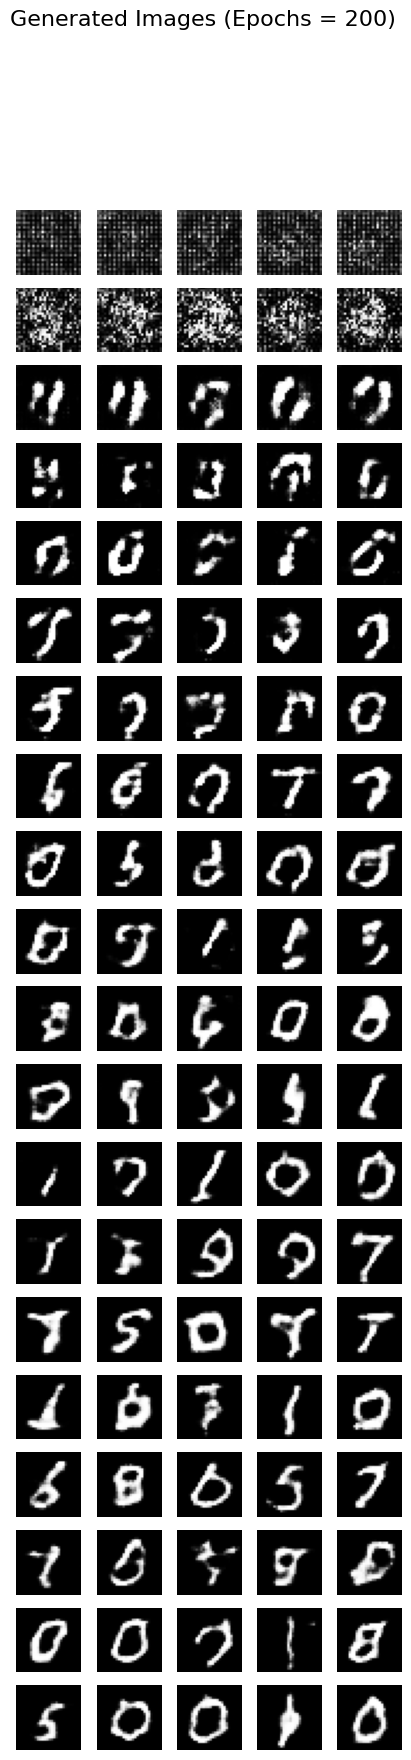

In [48]:
# Plotting the generated images
fig, axes = plt.subplots(len(generated_list), 5, figsize=(5, len(generated_list)))
for i in range(len(generated_list)):
    image_list = generated_list[i]
    for j in range(5):
        axes[i, j].imshow(image_list[j], cmap="gray")
        axes[i, j].axis('off')
plt.suptitle(f"Generated Images (Epochs = {epochs})", fontsize=16)
plt.show()

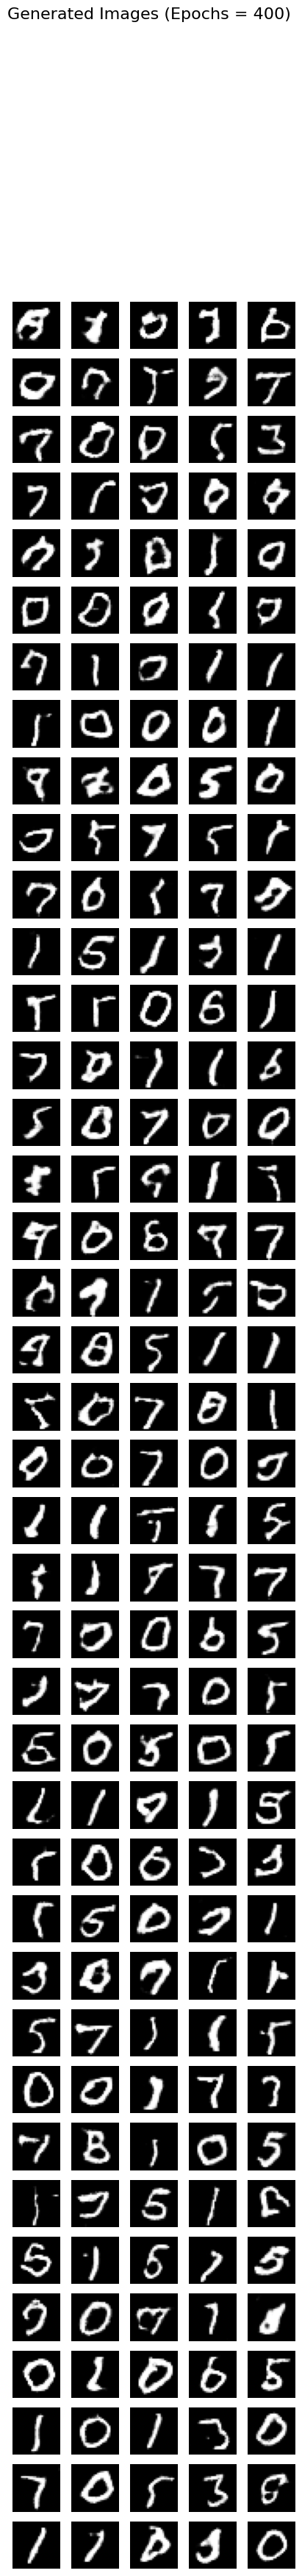

In [52]:
fig, axes = plt.subplots(len(generated_list_doubled), 5, figsize=(5, len(generated_list_doubled)))
for i in range(len(generated_list_doubled)):
    image_list=generated_list_doubled[i]
    for j in range(5):
        axes[i, j].imshow(image_list[j], cmap="gray")
        axes[i, j].axis('off')

plt.suptitle(f"Generated Images (Epochs = {epochs_doubled})", fontsize=16)
plt.show()

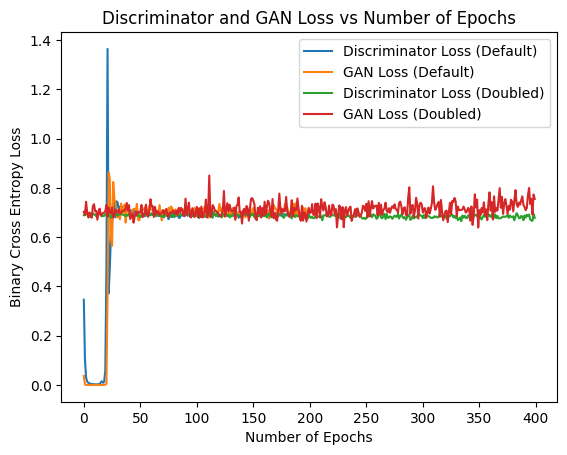

In [53]:
# Plotting the losses
plt.plot(discriminator_loss, label="Discriminator Loss (Default)")
plt.plot(gan_loss, label="GAN Loss (Default)")
plt.plot(discriminator_loss_doubled, label="Discriminator Loss (Doubled)")
plt.plot(gan_loss_doubled, label="GAN Loss (Doubled)")
plt.legend()
plt.title("Discriminator and GAN Loss vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

By doubling the epoch:

- The GAN gains additional chances to learn and fine-tune its parameters. This could yield generated images of superior quality, characterized by improved clarity, sharpness, and resemblance to the original data distribution.
  
- Prolonged training duration may help stabilize the training process, mitigating the risks of mode collapse or other instabilities. This enhanced stability can contribute to smoother convergence and more reliable performance overall.

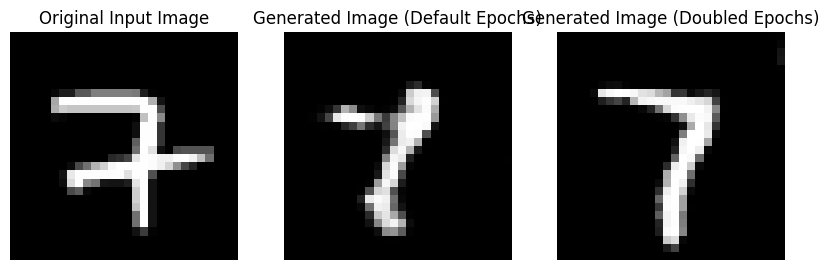

SSIM Score (Default Epochs): 0.21506993460270152
SSIM Score (Doubled Epochs): 0.35435713044849265


In [57]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Original input image of digit '7' (chosen arbitrarily)
original_image = train_images[np.where(y_train[:len(train_images)] == 7)[-1][0]]

# Generated images from default number of epochs and doubled number of epochs
generated_image_default = generated_list[-3][0]  # Last generated image from default epochs
generated_image_doubled = generated_list_doubled[-2][0]  # Last generated image from doubled epochs

# Display original input image and generated images
plt.figure(figsize=(10, 5))

# Original input image
plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Generated image from default epochs
plt.subplot(1, 3, 2)
plt.imshow(generated_image_default.squeeze(), cmap='gray')
plt.title("200 epchos")
plt.axis('off')

# Generated image from doubled epochs
plt.subplot(1, 3, 3)
plt.imshow(generated_image_doubled.squeeze(), cmap='gray')
plt.title("400 epchos")
plt.axis('off')

plt.show()

# Calculate Structural Similarity Index (SSIM) between original and generated images
ssim_default = ssim(original_image.squeeze(), generated_image_default.squeeze())
ssim_doubled = ssim(original_image.squeeze(), generated_image_doubled.squeeze())

# Print SSIM scores
print("SSIM Score (Default Epochs):", ssim_default)
print("SSIM Score (Doubled Epochs):", ssim_doubled)


- At epoch=200, the displayed image exhibits minimal detail, although some curved and horizontal lines are discernible.
  
- By epoch=400, there's a noticeable enhancement in image quality, with lines and curves appearing noticeably smoother.